In [18]:
import os
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
path = '/home/vidhiwar/Data/mnist'
np.random.seed(10)

In [20]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y


class Softmax:
    def predict(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores)

    def loss(self, x, y):
        probs = self.predict(x)

        return -np.log(probs[y])

    def diff(self, x, y):
        probs = self.predict(x)
        probs[y] -= 1.0
        return probs

In [21]:
class LSTM_numpy(object):
    def __init__(self, input_size, hidden_size, output_size, bptt_truncate=4, LR = 0.00001):
        self.bptt_truncate = bptt_truncate
        self.state = np.zeros((hidden_size))
        self.hidden = np.zeros((hidden_size))
        self.learning_rate = LR
        
        self.Wf = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size + input_size))
        self.Wi = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size + input_size))
        self.Wc = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size + input_size))
        self.Wo = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size + input_size))
        self.Wv = np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (output_size, hidden_size))
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        self.softmax = Softmax()

    def forward_backward(self, x ,y):

        loss, acc, dLdWv, dLdWo, dLdWc, dLdWi, dLdWf = self.bptt(x, y)
        self.backward(dLdWv, dLdWo, dLdWc, dLdWi, dLdWf)
        
        return loss, acc

    def hidden_state_reset(self):
        self.hidden = np.zeros_like(self.hidden)
    
    def bptt(self, x, y):
        dLdWv = np.zeros_like(self.Wv.transpose())
        dLdWo = np.zeros_like(self.Wo.transpose())
        dLdWc = np.zeros_like(self.Wc.transpose())
        dLdWi = np.zeros_like(self.Wi.transpose())
        dLdWf = np.zeros_like(self.Wf.transpose())

        dc = np.zeros((self.hidden_size))
        dh = np.zeros((self.hidden_size))

        states, hiddens, outputs, zs, fs, inps, c_s, os = self.forward(x)
        loss = self.softmax.loss(outputs[-1],y)
        pred = np.argmax(self.softmax.predict(outputs[-1]))
        if pred == y:
            acc = 1
        else:
            acc = 0
            
        outputs = self.softmax.predict(outputs)
        dv = outputs[-1]
        dv[y] = dv[y] - 1
        dLdWv += np.outer(hiddens[-1], dv)

        for j in reversed(range(len(states))):
            dh = dh + dv.dot(self.Wv)
            do = dh * tanh(states[j])
            dc = dc + dh * os[j] * dtanh(states[j])
            dc1 = dc * inps[j]
            di = dc * c_s[j]
            df = dc * states[j - 1]
            dc = fs[j] * dc
            dff = dsigmoid(fs[j]) * df
            dii = dsigmoid(inps[j]) * di
            dc2 = dtanh(c_s[j]) * dc1
            doo = dsigmoid(os[j]) * do
            dz = dff.dot(self.Wf) + di.dot(self.Wi) + dc1.dot(self.Wc) + do.dot(self.Wo)
            dh = dz[self.input_size:]
            
            dLdWf = np.outer(zs[j], dff)
            dLdWi = np.outer(zs[j], dii)
            dLdWc = np.outer(zs[j], dc2)
            dLdWo = np.outer(zs[j], doo)

        return [loss, acc, dLdWv, dLdWo, dLdWc, dLdWi, dLdWf]
    
    def forward(self, x):
        states  = np.zeros((len(x), self.state.shape[0]))
        hiddens = np.zeros((len(x), self.hidden.shape[0]))
        outputs = np.zeros((len(x), self.Wv.shape[0]))
        os = np.zeros((len(x), self.Wo.shape[0]))
        c_s = np.zeros((len(x), self.Wc.shape[0]))
        inps = np.zeros((len(x), self.Wi.shape[0]))
        zs = np.zeros((len(x), self.input_size + self.hidden_size))
        fs = np.zeros((len(x), self.Wf.shape[0]))

        c = np.zeros_like(self.state)
        h = np.zeros_like(self.hidden)

        for k in range(len(x)):
            z = np.concatenate((h, x[k]), axis=0)
            f = sigmoid(self.Wf.dot(z))
            i = sigmoid(self.Wi.dot(z))
            c1 = tanh(self.Wc.dot(z))
            c = tanh(f * c1 + i * c)
            o = sigmoid(self.Wo.dot(z))
            h = o * tanh(c)
            out = self.Wv.dot(h)

            states[k]  = c
            hiddens[k] = h
            inps[k] = i
            zs[k] = z
            fs[k] = f
            c_s[k] = c1
            os[k] = o

            outputs[k] = out

        return states, hiddens, outputs, zs, fs, inps, c_s, os
    
    def backward(self,dLdWv, dLdWo, dLdWc, dLdWi, dLdWf):
        
        self.Wv -= self.learning_rate * dLdWv.transpose()
        self.Wo -= self.learning_rate * dLdWo.transpose()
        self.Wc -= self.learning_rate * dLdWc.transpose()
        self.Wi -= self.learning_rate * dLdWi.transpose()
        self.Wf -= self.learning_rate * dLdWf.transpose()


In [22]:
class LSTM_torch(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE):
        super(LSTM_torch, self).__init__()
        self.rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=1, batch_first=True)
        self.fc = nn.Linear(HIDDEN_SIZE,OUTPUT_SIZE)
    def forward(self,x):
        out,_ = self.rnn(x,None)
        out = self.fc(out[:,-1,:])
        return out

In [23]:
EPOCH = 10
BATCH_SIZE = 1
TIME_STEP = 28
INPUT_SIZE = 28
HIDDEN_SIZE = 64
OUTPUT_SIZE = 10

LR = 0.00001
device = 'cuda'

train_data = torchvision.datasets.MNIST(root=path,
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)
test_data = torchvision.datasets.MNIST(root=path,
                                        train=False,
                                        transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=False)

In [24]:
lstm = LSTM_numpy(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, LR=LR)
out_fn = Softmax()
loss_epoch_train = []
loss_epoch_test = []
acc_train = []
acc_val = []

for e in range(EPOCH):
    losses = []
    acc = []
    for x,y in tqdm(train_loader):
        x = torch.transpose(x,2,3)
        x = x.squeeze().tolist()
        y = y.squeeze().tolist()
        loss,a = lstm.forward_backward(x,y)
        if np.isnan(loss):
            print('NaN encountered. Stop Immediately!')
        losses.append(loss)
        acc.append(a)
    acc_train.append(np.sum(acc)*100/len(acc))

    loss_epoch_train.append(np.mean(losses))
    losses = []
    acc = []
    for x,y in test_loader:
        x = torch.transpose(x,2,3)
        x = x.squeeze().tolist()
        y = y.squeeze().tolist()

        _,_,outputs,_,_,_,_,_ = lstm.forward(x)
        y_pred = np.argmax(out_fn.predict(outputs[-1]))
        loss = out_fn.loss(outputs[-1],y)
        losses.append(loss)
        acc.append(y_pred == y)
    acc_val.append(np.sum(acc)*100/len(acc))
    loss_epoch_test.append(np.mean(losses))
    print('Epoch:',int(e),' Train loss:',loss_epoch_train[e],' Test loss:'
          ,loss_epoch_test[e],' Train accuracy:',acc_train[e],' Test accuracy:',acc_val[e])



  0%|          | 31/60000 [00:00<03:14, 308.22it/s]

Epoch: 0  Train loss: 2.3028538925735824  Test loss: 2.3028667680627817  Train accuracy: 7.913333333333333  Test accuracy: 8.07


  0%|          | 28/60000 [00:00<03:35, 278.89it/s]

Epoch: 1  Train loss: 2.3028391079862316  Test loss: 2.3028518626370595  Train accuracy: 7.946666666666666  Test accuracy: 8.1


  0%|          | 32/60000 [00:00<03:09, 316.10it/s]

Epoch: 2  Train loss: 2.3028243244982964  Test loss: 2.3028369576857766  Train accuracy: 7.986666666666666  Test accuracy: 8.09


  0%|          | 35/60000 [00:00<02:53, 345.70it/s]

Epoch: 3  Train loss: 2.3028095405678335  Test loss: 2.302822053209151  Train accuracy: 7.998333333333333  Test accuracy: 8.08


  0%|          | 35/60000 [00:00<02:54, 342.78it/s]

Epoch: 4  Train loss: 2.3027947568859095  Test loss: 2.302807149205789  Train accuracy: 8.031666666666666  Test accuracy: 8.16


  0%|          | 34/60000 [00:00<02:58, 336.48it/s]

Epoch: 5  Train loss: 2.3027799744373594  Test loss: 2.3027922456765824  Train accuracy: 8.073333333333334  Test accuracy: 8.15


  0%|          | 37/60000 [00:00<02:43, 365.73it/s]

Epoch: 6  Train loss: 2.3027651922760506  Test loss: 2.302777342620947  Train accuracy: 8.115  Test accuracy: 8.17


  0%|          | 37/60000 [00:00<02:42, 368.53it/s]

Epoch: 7  Train loss: 2.302750410363974  Test loss: 2.3027624400405906  Train accuracy: 8.145  Test accuracy: 8.23


  0%|          | 35/60000 [00:00<02:53, 344.63it/s]

Epoch: 8  Train loss: 2.3027356289252525  Test loss: 2.3027475379320146  Train accuracy: 8.181666666666667  Test accuracy: 8.23


100%|██████████| 60000/60000 [02:32<00:00, 393.25it/s]


Epoch: 9  Train loss: 2.3027208483704373  Test loss: 2.302732636295951  Train accuracy: 8.23  Test accuracy: 8.26


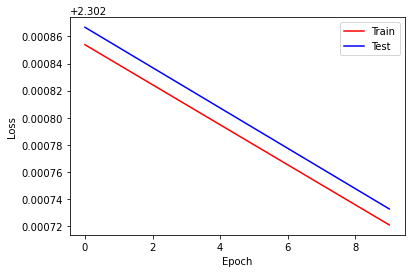

In [25]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(loss_epoch_train)), loss_epoch_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(loss_epoch_test)), loss_epoch_test, 'b',label='Test') 
plt.legend()
plt.show()

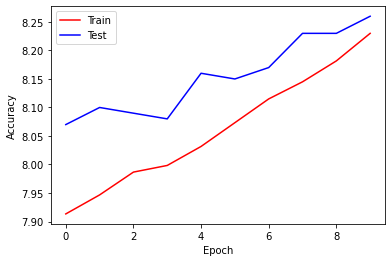

In [26]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(len(acc_train)), acc_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(acc_val)), acc_val, 'b',label='Test') 
plt.legend()
plt.show()


In [29]:
lstm = LSTM_torch(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
optimizer=torch.optim.SGD(lstm.parameters(),lr=LR)
loss_func=nn.CrossEntropyLoss()
loss_epoch_train = []
loss_epoch_test = []
acc_train = []
acc_val = []

lstm = lstm.to(device)

for e in range(EPOCH):
    losses = []
    acc = []
    for x,y in tqdm(train_loader):
        x = torch.transpose(x,2,3)
        x = x.squeeze(1)
        x = x.to(device)
        y = y.to(device)        
        outputs = lstm(x)
        loss = loss_func(outputs, y)
        optimizer.zero_grad()        
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        y_pred = torch.argmax(outputs, dim=1)
        acc.append((y_pred == y).float().cpu().numpy())

    acc_train.append(np.sum(acc)*100/len(acc))

    loss_epoch_train.append(np.mean(losses))
    losses = []
    acc = []
    for x,y in test_loader:
        x = torch.transpose(x,2,3)
        x = x.squeeze(1)

        x = x.to(device)
        y = y.to(device)
        
        outputs = lstm(x)
        loss = loss_func(outputs, y)
        losses.append(loss.detach().cpu().numpy())
        y_pred = torch.argmax(outputs, dim=1)
        acc.append((y_pred == y).float().cpu().numpy())
    acc_val.append(np.sum(acc)*100/len(acc))
    loss_epoch_test.append(np.mean(losses))
    print('Epoch:',int(e),' Train loss:',loss_epoch_train[e],' Test loss:'
          ,loss_epoch_test[e],' Train accuracy:',acc_train[e],' Test accuracy:',acc_val[e])

  0%|          | 57/60000 [00:00<01:45, 569.89it/s]

Epoch: 0  Train loss: 2.3084161  Test loss: 2.3061092  Train accuracy: 9.733333333333333  Test accuracy: 9.69


  0%|          | 57/60000 [00:00<01:45, 566.44it/s]

Epoch: 1  Train loss: 2.3047445  Test loss: 2.302959  Train accuracy: 9.648333333333333  Test accuracy: 10.3


  0%|          | 65/60000 [00:00<01:33, 643.90it/s]

Epoch: 2  Train loss: 2.3018649  Test loss: 2.3003187  Train accuracy: 10.236666666666666  Test accuracy: 10.04


  0%|          | 64/60000 [00:00<01:34, 632.48it/s]

Epoch: 3  Train loss: 2.2992363  Test loss: 2.2976675  Train accuracy: 11.47  Test accuracy: 16.78


  0%|          | 57/60000 [00:00<01:45, 568.59it/s]

Epoch: 4  Train loss: 2.2962642  Test loss: 2.294272  Train accuracy: 15.61  Test accuracy: 14.56


  0%|          | 46/60000 [00:00<02:11, 455.39it/s]

Epoch: 5  Train loss: 2.2918718  Test loss: 2.2885318  Train accuracy: 14.793333333333333  Test accuracy: 14.71


  0%|          | 55/60000 [00:00<01:50, 543.44it/s]

Epoch: 6  Train loss: 2.2831442  Test loss: 2.2755272  Train accuracy: 16.39666666666667  Test accuracy: 19.3


  0%|          | 45/60000 [00:00<02:13, 448.78it/s]

Epoch: 7  Train loss: 2.2595632  Test loss: 2.2323081  Train accuracy: 22.695  Test accuracy: 23.04


  0%|          | 36/60000 [00:00<02:47, 358.75it/s]

Epoch: 8  Train loss: 2.1875908  Test loss: 2.1583905  Train accuracy: 20.993333333333332  Test accuracy: 20.36


100%|██████████| 60000/60000 [02:00<00:00, 496.22it/s]


Epoch: 9  Train loss: 2.1458743  Test loss: 2.1263556  Train accuracy: 20.44  Test accuracy: 20.75


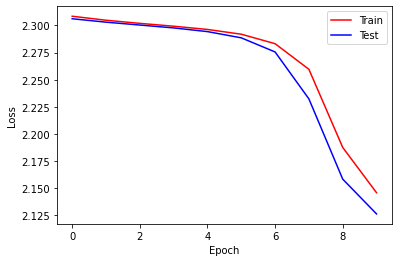

In [30]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(len(loss_epoch_train)), loss_epoch_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(loss_epoch_test)), loss_epoch_test, 'b',label='Test') 
plt.legend()
plt.show()

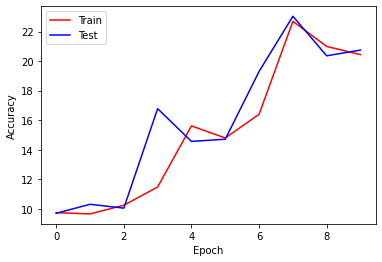

In [31]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(len(acc_train)), acc_train, 'r',label='Train') # plotting t, a separately 
plt.plot(range(len(acc_val)), acc_val, 'b',label='Test') 
plt.legend()
plt.show()
